Your Name and PRN:
- Name: Snehal Awadan
- PRN : 240340128033
- Date: 2/06/2024

# Image Processing with Neural Network

## Assignment: A04
### Take Neural Network with :
- Multiple hidden layers 
- Activation function of your choice


### Assignment
- **Q1**: Is this model more accurate compared to previous model?
- **Q2**: Prepare table by changing number of neurons in hidden layer, learning rate and observe change in results. Also comment on your results.

|#|Learning rate|Epochs|Optimizer|Activation|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:--|
|1|0.001|50|adam|tanh|0.99790|0.9790|Base case|
|2|0.1|10|adam|relu|0.99560|0.97730|Best from privious model|
|3|0.05|10|adam|relu|0.99756|0.98010|it is worst from prevous worst|
|5|0.05|10|RMSprop|relu|0.99698|0.98060|It show loss curve getting smooth but val_los incresing , it wrost frro previous|
|6|0.65|10|RMSprp|selu|0.99416|0.93070|It shows smooth loss curve and vl_loss has sydden hike and drop , It Not good model.|
|7|0.01|50|SGD|relu|0.9916|9816|In this graph of losses and accuracy both are smooth it is best mode till now. Erros is also low compare to othrs model.|
|8|0.05|50|SGD|relu|1|0.9826|In this erros is increse from previous and losses are are not close to eache other , so this is wrost from previous|

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay



In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'
logDir = '../logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 10 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.65  # learning rate
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

PATIENCE = 20
LR_PATIENCE  = 10
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [4]:
###------------------------------------------------
### Plot Loss Curve using Tensorflow history object
###------------------------------------------------
def fn_plot_tf_hist(hist_df):
    
    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    '''
        
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)
    
    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0
    
    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0] + offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid();
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0]-offset), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()
    


In [5]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Data Loading

In [6]:
mnist = tf.keras.datasets.mnist

In [7]:
# Data split int train and test 

(X_train_full, y_train_full),(X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step


In [8]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [9]:
X_test.shape, X_test.dtype

((10000, 28, 28), dtype('uint8'))

In [10]:
y_train_full.shape, y_train_full.dtype

((60000,), dtype('uint8'))

In [12]:
# data for validation

X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]



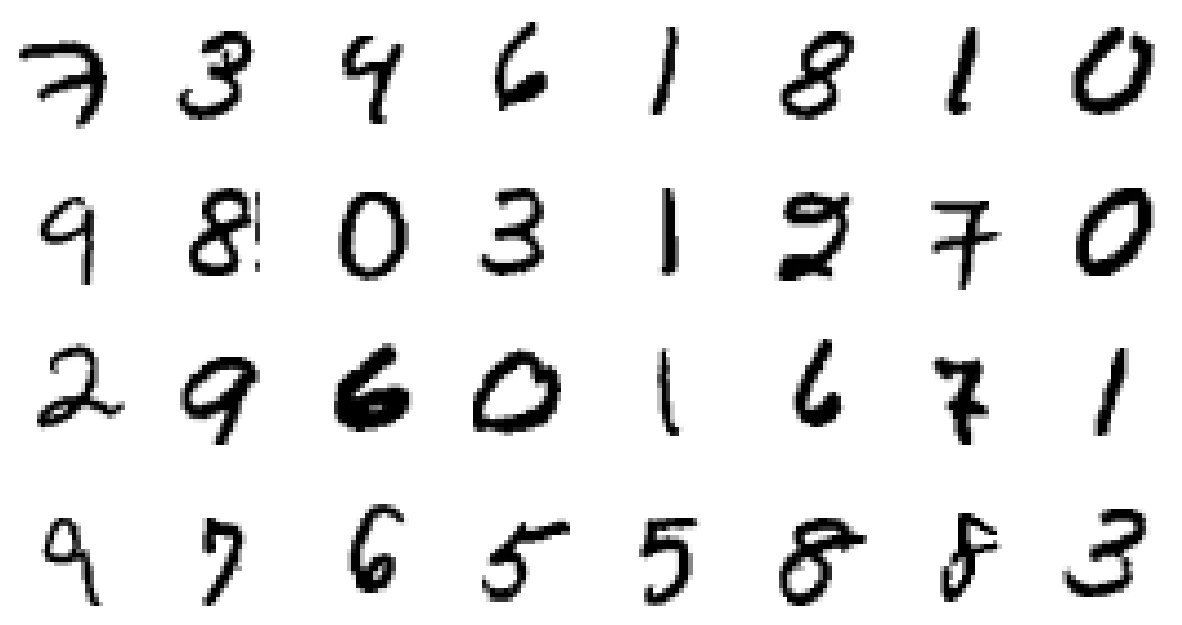

In [15]:
plt.figure(figsize= (15,8))

for i in range (BATCH_SIZE):
    plt.subplot(4,8,i+1)
    plt.imshow(X_train[i].reshape(28,28),cmap  =  plt.cm.binary)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    

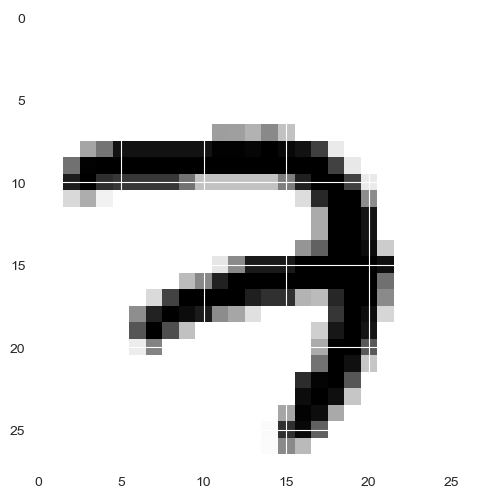

7

In [17]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('on')
plt.show()
y_train[0]

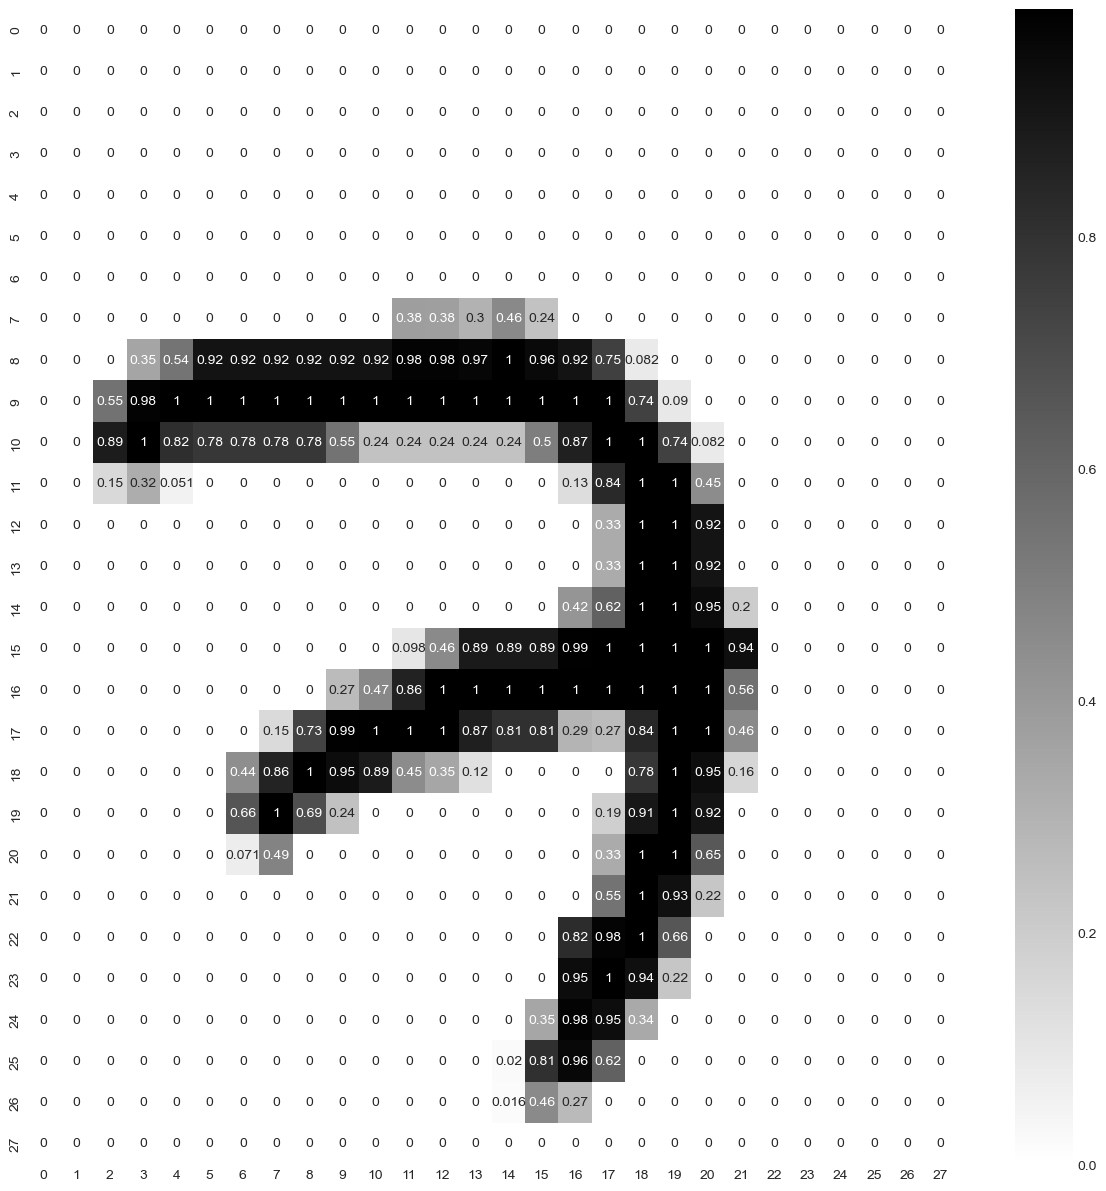

In [18]:
# Heatmap
plt.figure(figsize=(15,15))
sns.heatmap(X_train[0], annot=True, cmap="binary")
plt.show()


In [19]:
# Hiiden layers in model

Layers = [tf.keras.layers.Flatten(input_shape=[28,28], name="inputLayer"),
          tf.keras.layers.Dense(300, activation="relu", name="hiddenLayer1"),
          tf.keras.layers.Dense(100, activation="relu", name="hiddenLayer2"),
          tf.keras.layers.Dense(10, activation="softmax", name="outputLayer")]

C:\Users\Rohit\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
# Model creating
model = tf.keras.models.Sequential(Layers)

In [21]:
model.layers

[<Flatten name=inputLayer, built=True>,
 <Dense name=hiddenLayer1, built=True>,
 <Dense name=hiddenLayer2, built=True>,
 <Dense name=outputLayer, built=True>]

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inputLayer (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer1 (Dense)            │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hiddenLayer2 (Dense)            │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputLayer (Dense)             │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
hidden1 = model.layers[1]
model.get_layer(hidden1.name)

<Dense name=hiddenLayer1, built=True>

In [24]:
hidden1.get_weights()

[array([[ 0.04783885,  0.07257049,  0.04204743, ..., -0.05975387,
          0.05969946,  0.02999619],
        [ 0.0543268 ,  0.00181616,  0.02652401, ...,  0.0419918 ,
         -0.00644016,  0.05666015],
        [ 0.04317156,  0.03113325, -0.05815142, ...,  0.06478526,
         -0.01981327, -0.02544781],
        ...,
        [-0.04126506, -0.01141497,  0.07423803, ..., -0.00220684,
         -0.02704693,  0.01017651],
        [-0.03255725, -0.05272733, -0.07147351, ..., -0.0443741 ,
         -0.02514722, -0.03599124],
        [-0.00430017, -0.04937826, -0.02581044, ..., -0.0233284 ,
          0.01377743,  0.02211692]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [25]:
ALPHA = 0.1
LOSS_Function =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=ALPHA)
METRICS = ["accuracy"]


model.compile(loss=LOSS_Function, optimizer=OPTIMIZER, metrics=METRICS)

In [27]:
LOSS_Function = "sparse_categorical_crossentropy"
OPTIMIZER = 'SGD'
METRICS = ["accuracy"]


model.compile(loss=LOSS_Function, optimizer= OPTIMIZER, metrics=METRICS)

In [28]:
vALIDATION_SET = (X_valid, y_valid)

history = model.fit(X_train, y_train, epochs=50, validation_data=vALIDATION_SET)

Epoch 1/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7097 - loss: 1.0887 - val_accuracy: 0.9130 - val_loss: 0.3184
Epoch 2/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9146 - loss: 0.3029 - val_accuracy: 0.9342 - val_loss: 0.2386
Epoch 3/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9321 - loss: 0.2412 - val_accuracy: 0.9444 - val_loss: 0.2038
Epoch 4/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9403 - loss: 0.2062 - val_accuracy: 0.9520 - val_loss: 0.1785
Epoch 5/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9486 - loss: 0.1827 - val_accuracy: 0.9550 - val_loss: 0.1600
Epoch 6/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9559 - loss: 0.1558 - val_accuracy: 0.9590 - val_loss: 0.1470
Epoch 7/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9583 - loss: 0.1448 - val_accuracy: 0.9626 - val_loss: 0.1366
Epoch 8/50
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9642 - loss: 0.1264 - 

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9990 - loss: 0.0096 - val_accuracy: 0.9820 - val_loss: 0.0650


In [30]:
 # Model ecal:

model.evaluate ( X_test,  y_test, verbose=2)

313/313 - 0s - 1ms/step - accuracy: 0.9770 - loss: 14.6739


[14.673925399780273, 0.9769999980926514]

In [31]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.835200,0.639669,0.9130,0.318412
1,0.918345,0.286840,0.9342,0.238604
2,0.933527,0.234244,0.9444,0.203792
3,0.942436,0.200524,0.9520,0.178471
4,0.950418,0.175429,0.9550,0.160036


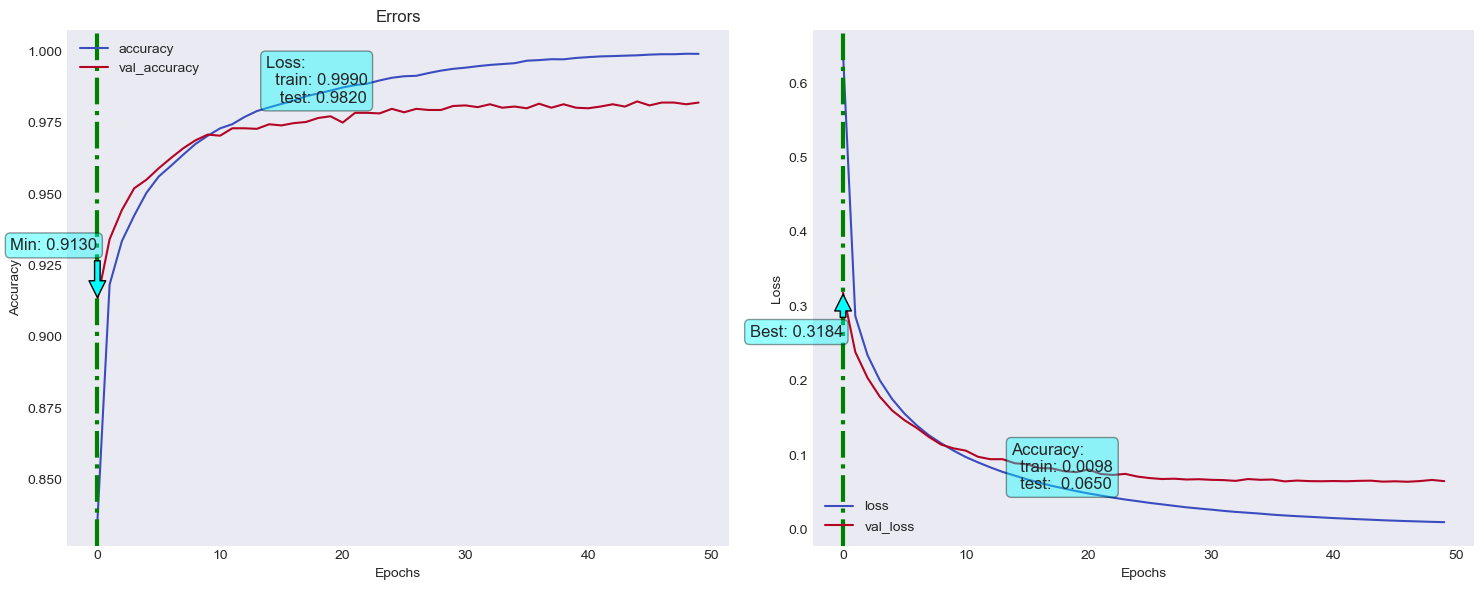

In [32]:
fn_plot_tf_hist(loss_df)


In [33]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,accuracy,loss,val_accuracy,val_loss
46,0.998909,0.011252,0.982,0.064186


Optimizer : Adam

Activation : Tanh and softmax

Epochs : 50

Learnnig Rate 0.001

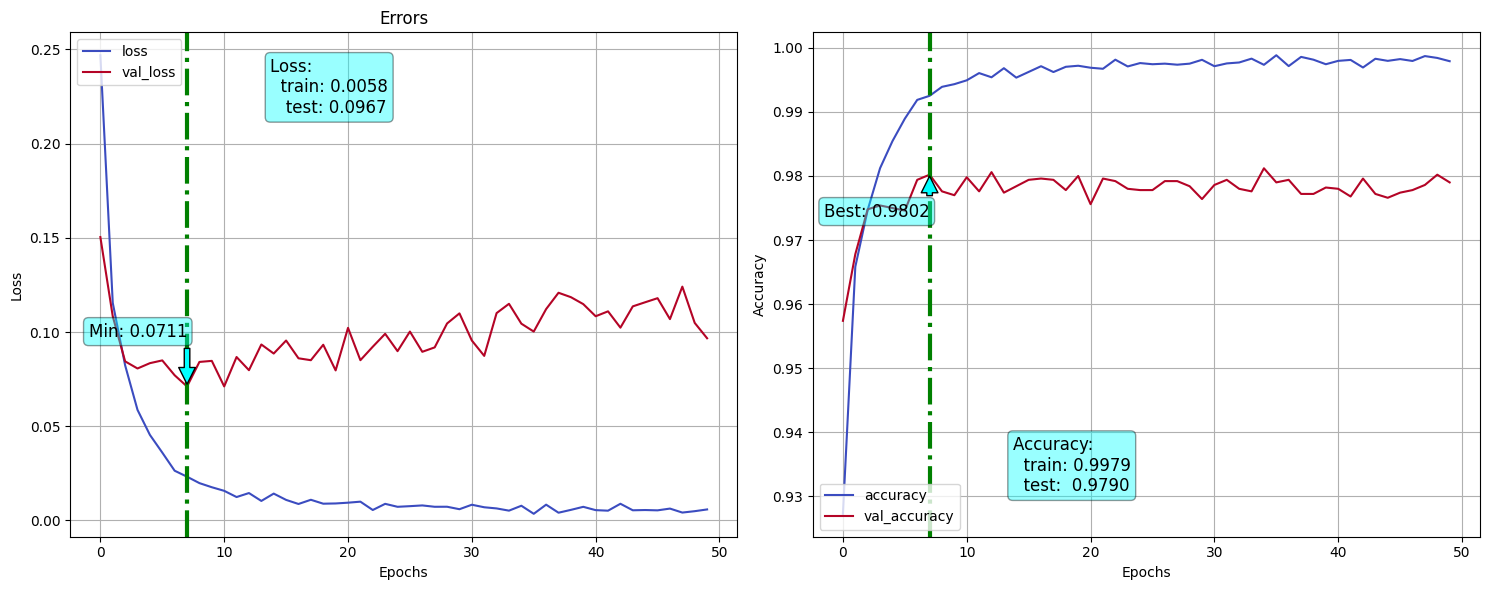

Optimizer : Adam

Activation : relu and softmax

Epoch : 10

Learnnig Rate 0.1


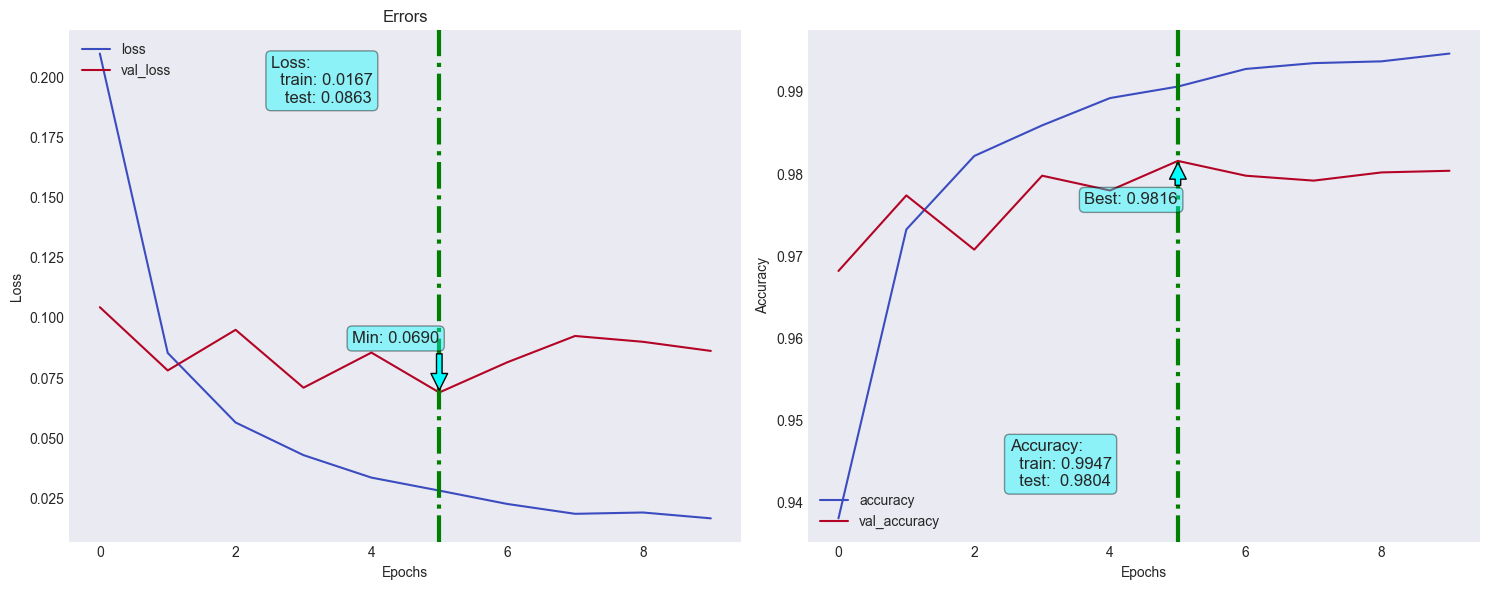


Optimizer : Adam

Activation : relu and softmax

Epochs : 10

Learnnig Rate 0.05

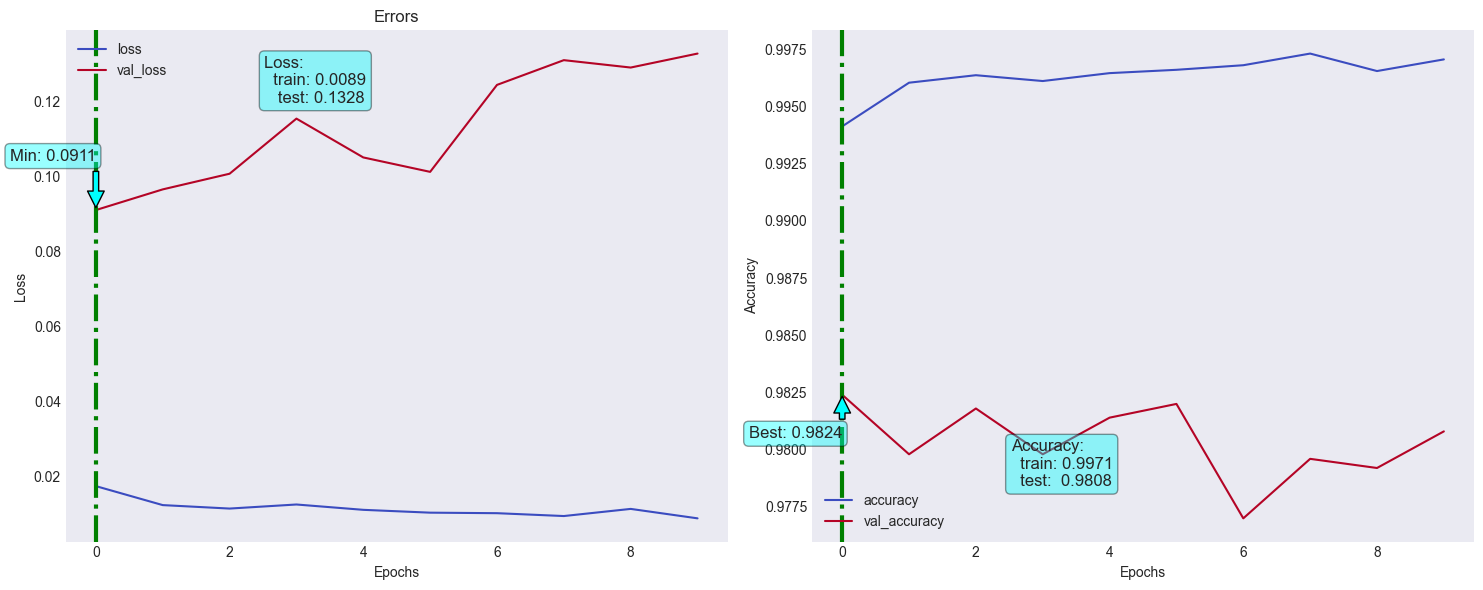


Optimizer : Adam

Activation : relu and softmax

Epochs : 10

Learnnig Rate 0.05


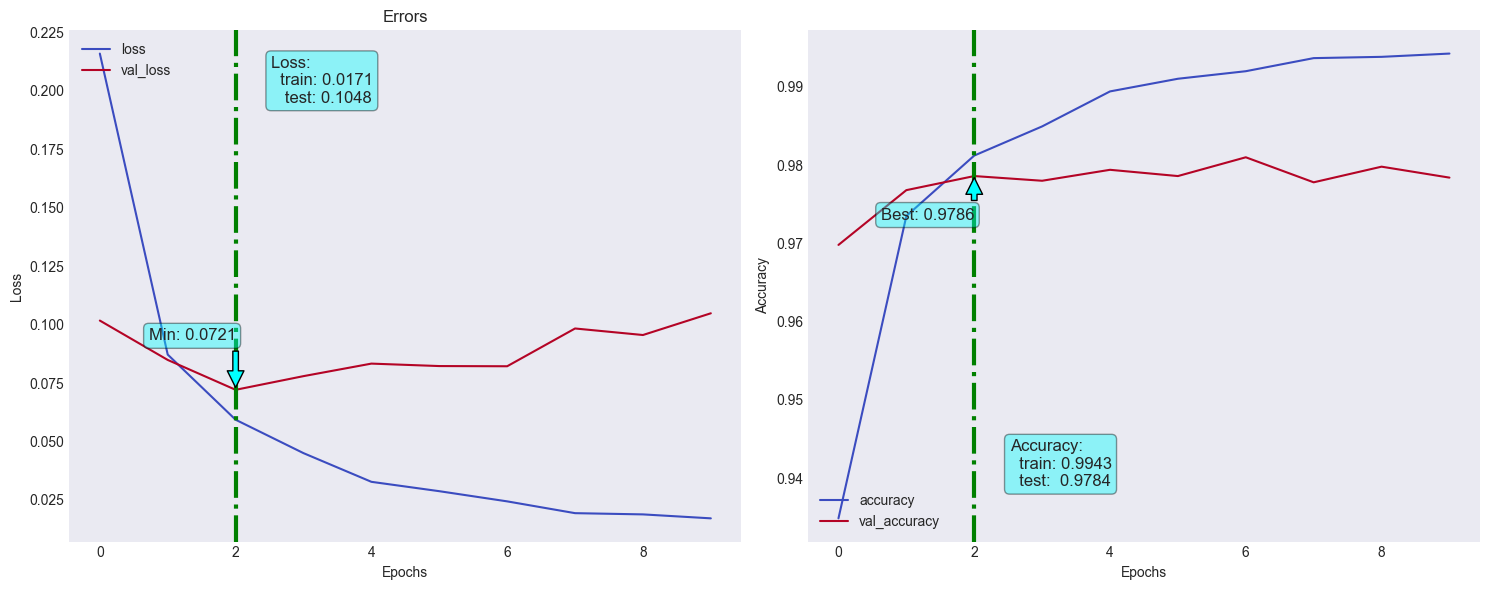




Optimizer : RMSprop

Activation : relu and softmax

Epochs : 10

Learnnig Rate 0.05


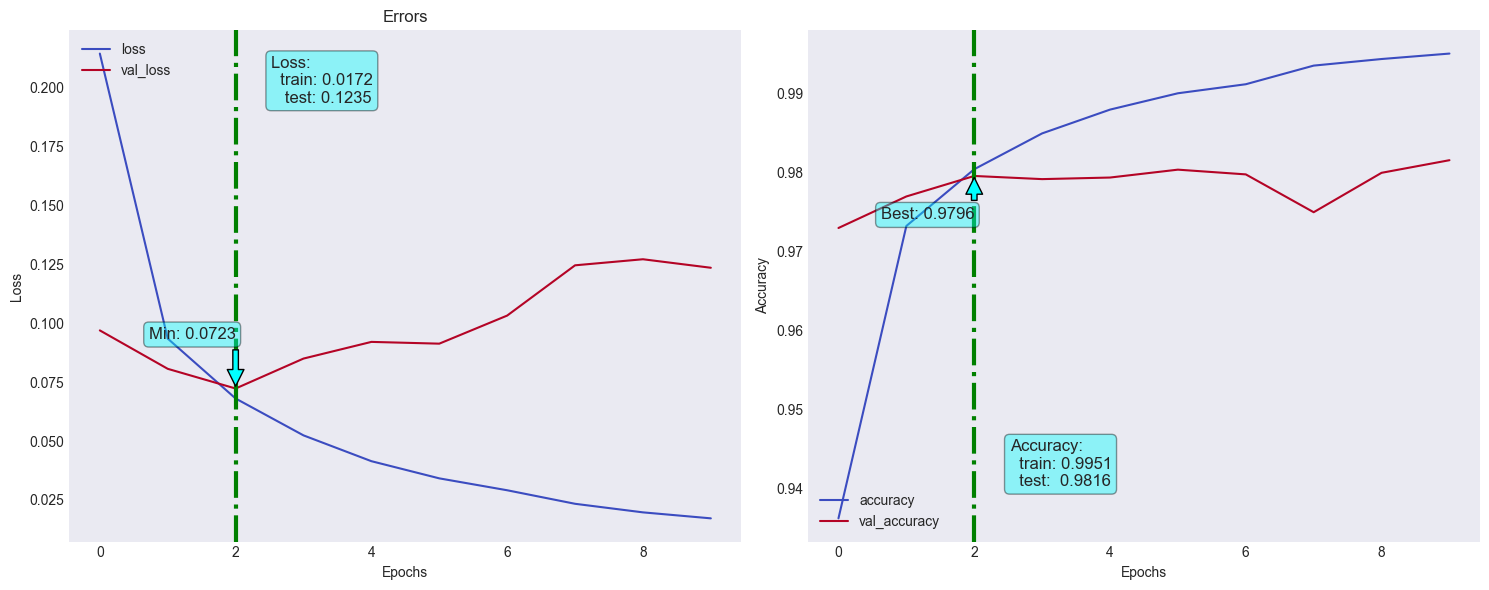





Optimizer : SGD

Activation : relu and softmax

Epochs : 50

Learnnig Rate 0.01 (default)

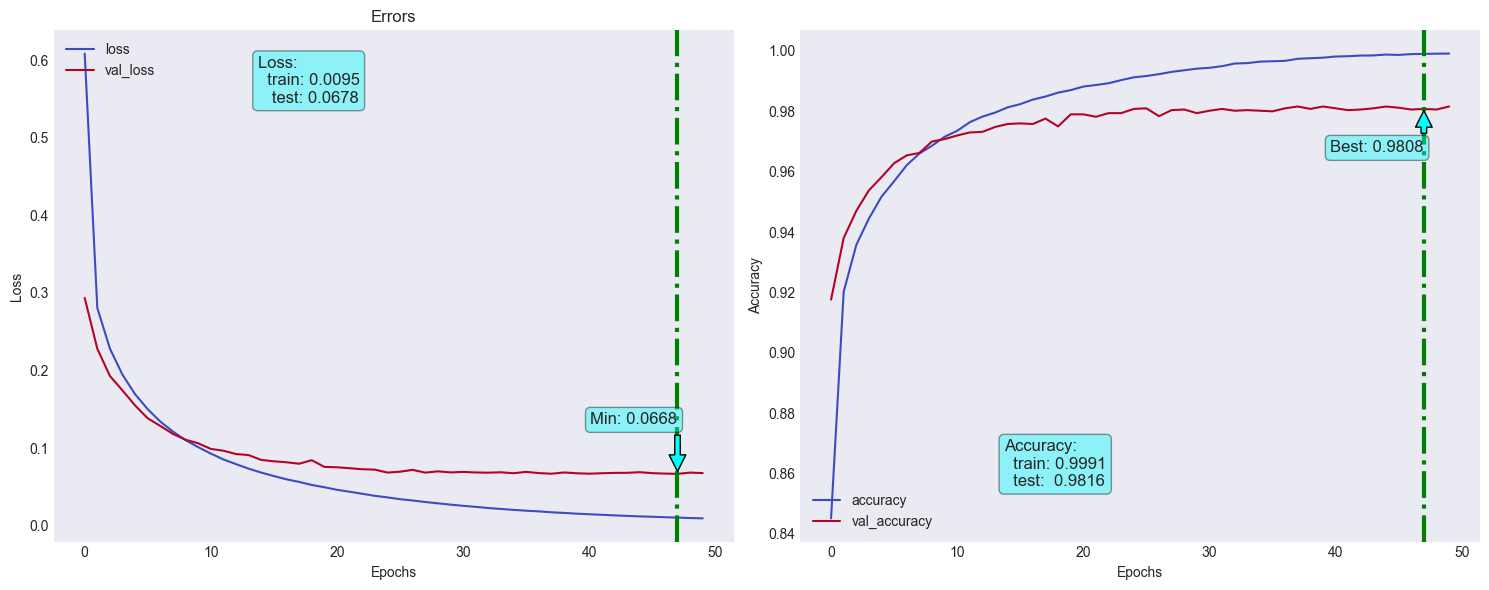




Optimizer : SGD

Activation : relu and softmax

Epochs : 50

Learnnig Rate 0.05



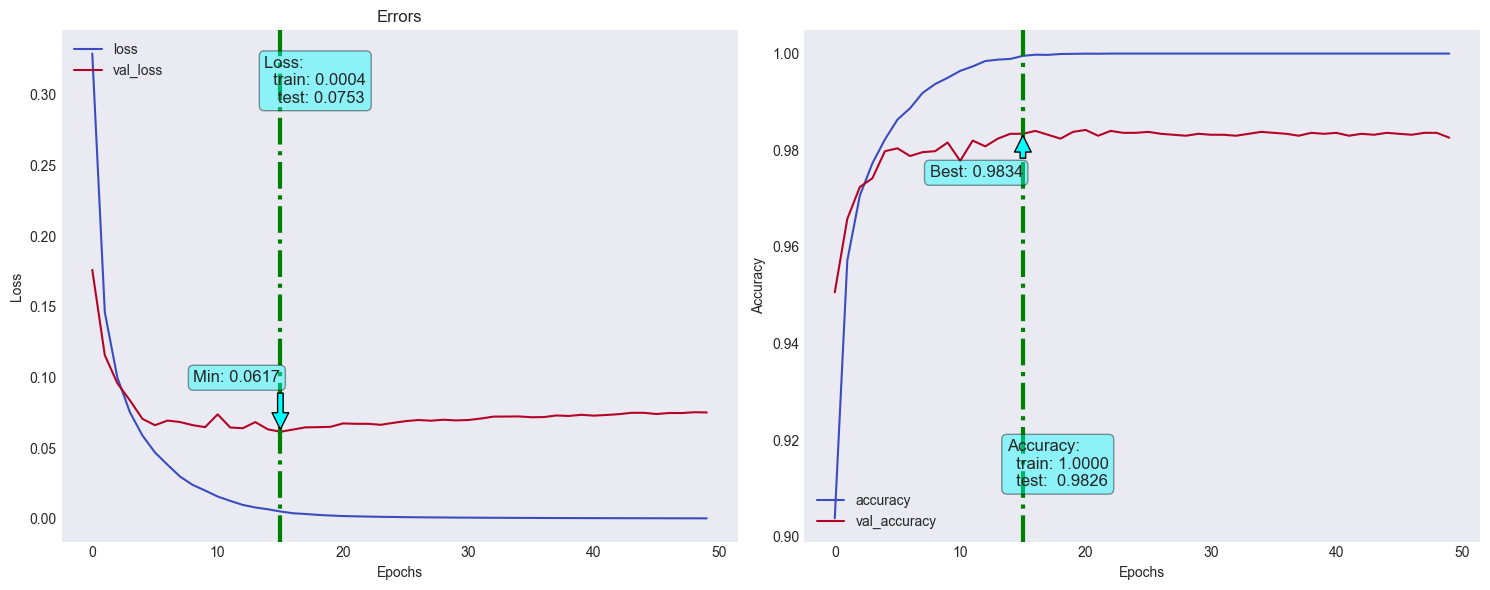





# Prediction

In [34]:
model.save("model.h5")

Train Dataset

In [95]:
loaded_model = tf.keras.models.load_model("model.h5")

In [96]:
X_new = X_test[:3]
y_new = y_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 114ms/step


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [97]:
y_pred = np.argmax(y_proba, axis=-1)
y_pred, y_new

(array([7, 2, 1], dtype=int64), array([7, 2, 1], dtype=uint8))

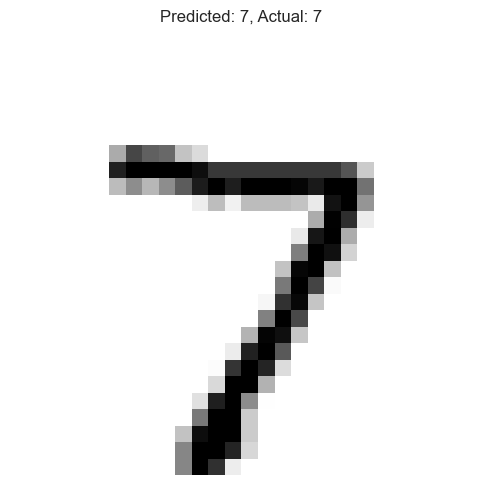

------------------------------------------------------------


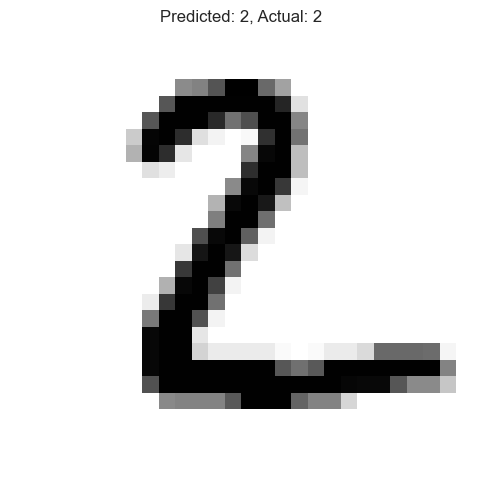

------------------------------------------------------------


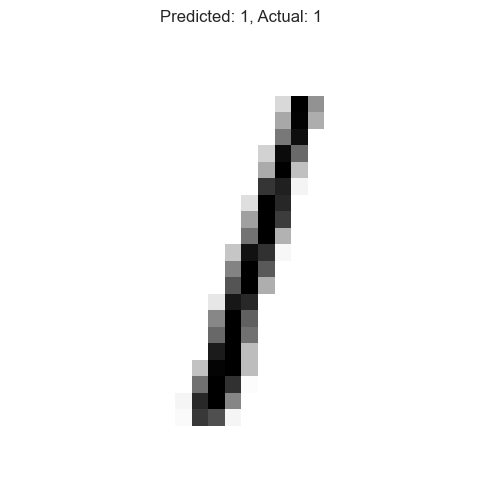

------------------------------------------------------------


In [98]:
for data, pred, actual in zip(X_new, y_pred, y_new):
  plt.imshow(data, cmap="binary")
  plt.title(f"Predicted: {pred}, Actual: {actual}")
  plt.axis("off")
  plt.show()
  print("---"*20)

# Answers:

|#|Learning rate|Epochs|Optimizer|Activation|Training Accuracy|Test Accuracy|Comment|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:--|
|1|0.001|50|adam|tanh|0.99790|0.9790|Base case|
|2|0.1|10|adam|relu|0.99560|0.97730|Best from privious model|
|3|0.05|10|adam|relu|0.99756|0.98010|it is worst from prevous worst|
|5|0.05|10|RMSprop|relu|0.99698|0.98060|It show loss curve getting smooth but val_los incresing , it wrost frro previous|
|6|0.65|10|RMSprp|selu|0.99416|0.93070|It shows smooth loss curve and vl_loss has sydden hike and drop , It Not good model.|
|7|0.01|50|SGD|relu|0.9916|9816|In this graph of losses and accuracy both are smooth it is best mode till now. Erros is also low compare to othrs model.|
|8|0.05|50|SGD|relu|1|0.9826|In this erros is increse from previous and losses are are not close to eache other , so this is wrost from previous|